# Evaluate Prediction API

## Import lib

In [17]:

import requests
from pathlib import Path
import pandas as pd
import json
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

In [18]:
API_ENDPOINT = 'http://localhost:8000/api'
ROOT_PATH = Path.cwd().parent

In [106]:
def plot_confuse(y_true, y_pred, labels=[]):
    if len(labels) > 0:
        yt = y_true.values if hasattr(y_true, "values") else np.asarray(y_true)
        yp = y_pred.values if hasattr(y_pred, "values") else np.asarray(y_pred)
        if yt.ndim != 1 or yp.ndim != 1:
            raise ValueError("For single-label, y_true and y_pred must be 1D.")
        if yt.shape[0] != yp.shape[0]:
            raise ValueError(f"Length mismatch: y_true {yt.shape[0]} vs y_pred {yp.shape[0]}")
        cm = confusion_matrix(yt, yp, labels=[0,1])
        _, ax = plt.subplots(figsize=(4.5, 4.5))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=labels if labels else [0,1])
        disp.plot(cmap=plt.cm.Blues, ax=ax, values_format="d", colorbar=False)
        plt.tight_layout()
        plt.show()

    else:
        cm_list = multilabel_confusion_matrix(y_true, y_pred)
        n = len(y_true.columns)
        _, axs = plt.subplots(1, n, figsize=(6*n, 5))
        for i in range(n):
            disp = ConfusionMatrixDisplay(confusion_matrix=cm_list[i], display_labels=[f"Not {y_true.columns[i]}", y_true.columns[i]])
            disp.plot(cmap=plt.cm.Blues, ax=axs[i] if n > 1 else axs, values_format="d", colorbar=False)
            axs[i].set_title(y_true.columns[i])
    plt.tight_layout()
    plt.show()

## Current Version

In [4]:
meta = requests.get(API_ENDPOINT + '/system/versions')
meta = meta.json()
print(json.dumps(meta, indent=4))

{
    "status": "Rug Pull Detection API is running.",
    "is_trained": true,
    "current_version": "20250825_151608_1_1",
    "timestamp": "2025-08-26T09:31:50.398328",
    "version_last_modified": "2025-08-26T06:41:53.979620",
    "label_names": [
        "Address Restrict",
        "Amount Restrict",
        "Hidden Balance Modification",
        "Hidden Mint/Burn",
        "Leak",
        "Limit",
        "Mint",
        "Modifiable External Call",
        "Modifiable Tax Address",
        "Modifiable Tax Rate",
        "TimeStamp Restrict",
        "Amount Limit",
        "Exchange Permission",
        "Exchange Suspension",
        "Fee Manipulation",
        "Invalid Callback",
        "Trapdoor"
    ],
    "n_labels": 17,
    "train_size": 1200,
    "test_size": 300,
    "notes": "Optuna 15 trials per model; test split=0.2.",
    "model_files": {
        "general_model": {
            "exists": true,
            "size": 313962,
            "mtime": "2025-08-26T03:24:03.950378"

## Evaluate on CRPWarning Ground Truth

In [ ]:
ground_df = pd.read_excel(ROOT_PATH / 'data/external/crpwarner/dataset/groundtruth/groundTruth.xlsx', index_col='address')
ground_df.index = ground_df.index.str.lower()

In [6]:
ground_df.head()

,Mint,Leak,Limit
address,,,
0x93023f1d3525e273f291b6f76d2f5027a39bf302,1,0,1
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1


In [7]:
res = requests.post(API_ENDPOINT + "/predict", json={"addresses": ground_df.index.to_list()})
print("Status:", res.status_code)
print("Elapsed:", res.elapsed.total_seconds(), "seconds")
res = res.json()['results']
df = pd.DataFrame.from_dict(res, orient="index")
df.head()

Status: 200
Elapsed: 213.620452 seconds


,labels,label_probs,anomaly,anomaly_score
0x93023f1d3525e273f291b6f76d2f5027a39bf302,"{'Address Restrict': 1, 'Amount Restrict': 1, ...","{'Address Restrict': 0.6057556970940429, 'Amou...",1,0.462258
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,"{'Address Restrict': 1, 'Amount Restrict': 0, ...","{'Address Restrict': 0.6905174535481907, 'Amou...",1,0.580088
0x94b7d24552933f50a5a5705c446528806dcea381,"{'Address Restrict': 0, 'Amount Restrict': 1, ...","{'Address Restrict': 0.21008467032827421, 'Amo...",1,0.462258
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,"{'Address Restrict': 0, 'Amount Restrict': 0, ...","{'Address Restrict': 0.21073564104015546, 'Amo...",1,0.462258
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,"{'Address Restrict': 0, 'Amount Restrict': 0, ...","{'Address Restrict': 0.17137202234071047, 'Amo...",1,0.462258


### Labels

In [8]:
label_df = pd.DataFrame.from_records(df['labels'].tolist(), index=df.index)
label_df.head()

,Address Restrict,Amount Restrict,Hidden Balance Modification,Hidden Mint/Burn,Leak,Limit,Mint,Modifiable External Call,Modifiable Tax Address,Modifiable Tax Rate,TimeStamp Restrict,Amount Limit,Exchange Permission,Exchange Suspension,Fee Manipulation,Invalid Callback,Trapdoor
0x93023f1d3525e273f291b6f76d2f5027a39bf302,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
0x94b7d24552933f50a5a5705c446528806dcea381,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,0,0,0,1,0,1,1,0,0,1,0,1,1,1,1,0,1


In [9]:
y_true = ground_df
y_pred = label_df.loc[y_true.index, y_true.columns]

In [10]:
y_true.head()

,Mint,Leak,Limit
address,,,
0x93023f1d3525e273f291b6f76d2f5027a39bf302,1,0,1
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1


In [11]:
y_pred.head()

,Mint,Leak,Limit
address,,,
0x93023f1d3525e273f291b6f76d2f5027a39bf302,1,0,1
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1


In [20]:
print(classification_report(
  y_true.values,
  y_pred.values,
  target_names=y_true.columns,
  zero_division=0))

              precision    recall  f1-score   support

        Mint       0.80      1.00      0.89        20
        Leak       0.89      0.89      0.89         9
       Limit       0.97      0.97      0.97        30

   micro avg       0.89      0.97      0.93        59
   macro avg       0.89      0.95      0.91        59
weighted avg       0.90      0.97      0.93        59
 samples avg       0.59      0.59      0.59        59



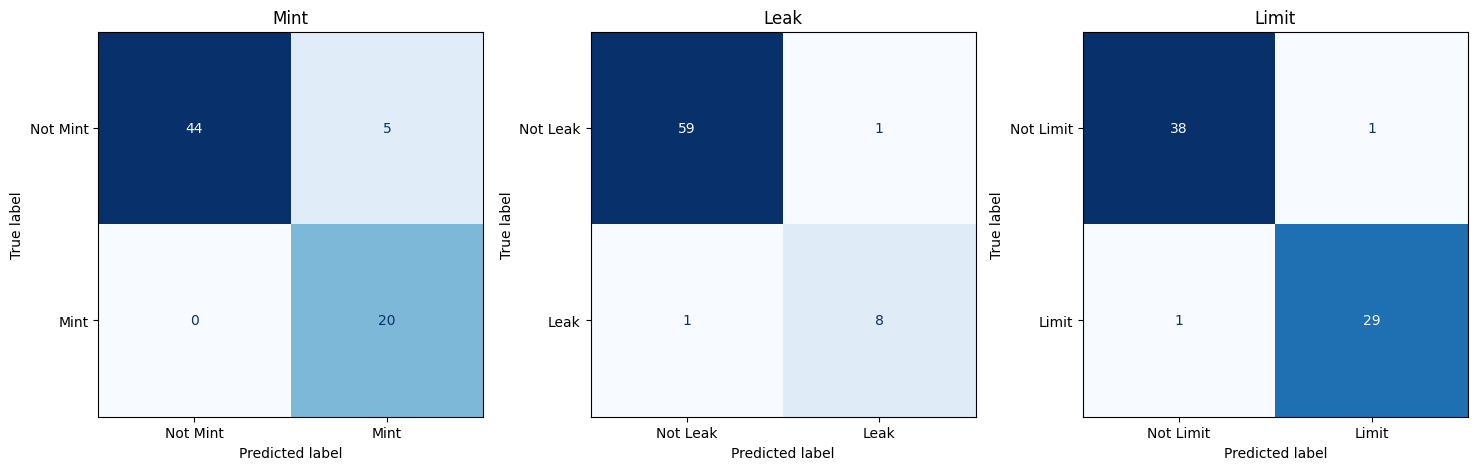

In [23]:
plot_confuse(y_true, y_pred)

### Anomaly

In [14]:
anomaly_true = (y_true.astype(int).sum(axis=1) > 0).astype(int)
anomaly_pred = df.loc[y_true.index, "anomaly"].astype(int)

In [15]:
labels = ['normal', 'anomaly']
print(classification_report(
  anomaly_true,
  anomaly_pred,
  target_names=labels,
  zero_division=0))

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        27
     anomaly       0.61      1.00      0.76        42

    accuracy                           0.61        69
   macro avg       0.30      0.50      0.38        69
weighted avg       0.37      0.61      0.46        69



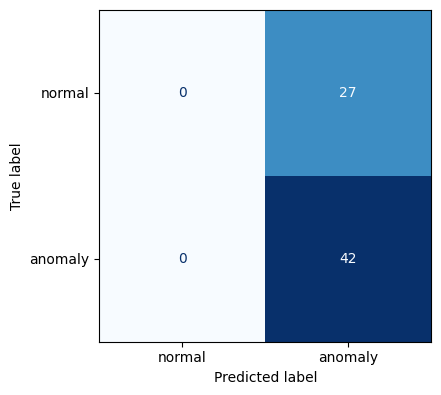

In [27]:
plot_confuse(anomaly_true, anomaly_pred, labels)

## Evaluate on Large Sample (Mint)

In [52]:
label = 'Mint'
temp_df = pd.read_excel(ROOT_PATH / f'data/external/crpwarner/dataset/large/sample/{label.lower()}.xlsx', index_col='Address')
temp_df['TP?'] = temp_df['TP?'].map({'Yes': 1, 'No': 0})
temp_df = temp_df.rename(columns={'TP?': label})
temp_df.index = temp_df.index.str.lower()

In [54]:
temp_df.head()

,Mint
Address,
0x0fef20d2c4ee011fa0389e69e9fa92a2291b63c8,1
0xd7cc0deb9dd11be95068bf2d7a3d082b8ba9bf04,1
0xa1b756be589441519b1a08e16bc4f60ab177d916,1
0x514bc174df04a4b04ae2be81ee8c788c3796b06b,1
0x1354c8c1a66c2573ce9cc3e92e98d17869501a46,1


In [31]:
res = requests.post(API_ENDPOINT + "/predict", json={"addresses": temp_df.index.to_list()})
print("Status:", res.status_code)
print("Elapsed:", res.elapsed.total_seconds(), "seconds")
res = res.json()['results']
df = pd.DataFrame.from_dict(res, orient="index")
df.head()

Status: 200
Elapsed: 288.838395 seconds


,labels,label_probs,anomaly,anomaly_score
0x0fef20d2c4ee011fa0389e69e9fa92a2291b63c8,"{'Address Restrict': 0, 'Amount Restrict': 0, ...","{'Address Restrict': 0.07362741922920765, 'Amo...",1,0.462258
0xd7cc0deb9dd11be95068bf2d7a3d082b8ba9bf04,"{'Address Restrict': 0, 'Amount Restrict': 1, ...","{'Address Restrict': 0.02257792597178286, 'Amo...",1,0.462258
0xa1b756be589441519b1a08e16bc4f60ab177d916,"{'Address Restrict': 0, 'Amount Restrict': 0, ...","{'Address Restrict': 0.06266966197385725, 'Amo...",1,0.580088
0x514bc174df04a4b04ae2be81ee8c788c3796b06b,"{'Address Restrict': 0, 'Amount Restrict': 0, ...","{'Address Restrict': 0.28235612910726376, 'Amo...",1,0.462258
0x1354c8c1a66c2573ce9cc3e92e98d17869501a46,"{'Address Restrict': 0, 'Amount Restrict': 1, ...","{'Address Restrict': 0.026694638981940244, 'Am...",1,0.462258


### Labels

In [32]:
label_df = pd.DataFrame.from_records(df['labels'].tolist(), index=df.index)
label_df.head()

,Address Restrict,Amount Restrict,Hidden Balance Modification,Hidden Mint/Burn,Leak,Limit,Mint,Modifiable External Call,Modifiable Tax Address,Modifiable Tax Rate,TimeStamp Restrict,Amount Limit,Exchange Permission,Exchange Suspension,Fee Manipulation,Invalid Callback,Trapdoor
0x0fef20d2c4ee011fa0389e69e9fa92a2291b63c8,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0
0xd7cc0deb9dd11be95068bf2d7a3d082b8ba9bf04,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
0xa1b756be589441519b1a08e16bc4f60ab177d916,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
0x514bc174df04a4b04ae2be81ee8c788c3796b06b,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1
0x1354c8c1a66c2573ce9cc3e92e98d17869501a46,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [33]:
y_true = temp_df
y_pred = label_df.loc[y_true.index, y_true.columns]

In [34]:
y_true.head()

,Mint
Address,
0x0fef20d2c4ee011fa0389e69e9fa92a2291b63c8,1
0xd7cc0deb9dd11be95068bf2d7a3d082b8ba9bf04,1
0xa1b756be589441519b1a08e16bc4f60ab177d916,1
0x514bc174df04a4b04ae2be81ee8c788c3796b06b,1
0x1354c8c1a66c2573ce9cc3e92e98d17869501a46,1


In [35]:
y_pred.head()

,Mint
Address,
0x0fef20d2c4ee011fa0389e69e9fa92a2291b63c8,1
0xd7cc0deb9dd11be95068bf2d7a3d082b8ba9bf04,1
0xa1b756be589441519b1a08e16bc4f60ab177d916,1
0x514bc174df04a4b04ae2be81ee8c788c3796b06b,1
0x1354c8c1a66c2573ce9cc3e92e98d17869501a46,1


In [36]:
labels = [f'No {label}', label]
print(classification_report(
  y_true.values,
  y_pred.values,
  target_names=labels,
  zero_division=0))

              precision    recall  f1-score   support

     No Mint       1.00      0.43      0.60        14
        Mint       0.91      1.00      0.95        78

    accuracy                           0.91        92
   macro avg       0.95      0.71      0.78        92
weighted avg       0.92      0.91      0.90        92



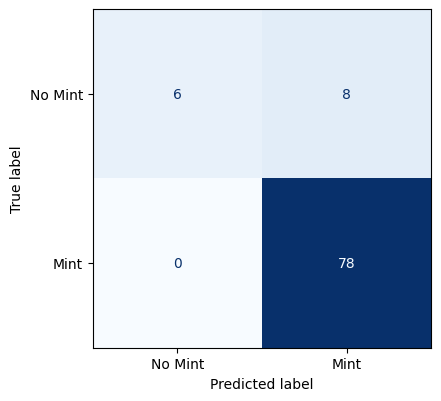

In [49]:
plot_confuse(y_true.iloc[:, 0].astype(int).to_numpy(), y_pred.iloc[:, 0].astype(int).to_numpy(), labels)

## Evaluate on Large Sample (Leak)

In [68]:
label = 'Leak'
temp_df = pd.read_excel(ROOT_PATH / f'data/external/crpwarner/dataset/large/sample/{label.lower()}.xlsx', index_col='Address')
temp_df['TP?'] = temp_df['TP?'].map({'Yes': 1, 'No': 0})
temp_df = temp_df.rename(columns={'TP?': label})
temp_df.index = temp_df.index.str.lower()

In [69]:
temp_df.head()

,Leak
Address,
0x0290ea3c728981725689187763f6c63a68e192b8,1
0x054ad3cd4a66f14bf5c0de2548a53be66995a4f6,1
0x0566c17dc2a9efcaa2f63e04cf06a69e8fc77f60,0
0x10c8324b20b7266c445944f043f53f6a77ea0bd4,1
0x10cc060f6f9b2e5dcdb23f1361e4b368a7daec73,1


In [70]:
res = requests.post(API_ENDPOINT + "/predict", json={"addresses": temp_df.index.to_list()})
print("Status:", res.status_code)
print("Elapsed:", res.elapsed.total_seconds(), "seconds")
res = res.json()['results']
df = pd.DataFrame.from_dict(res, orient="index")
df.head()

Status: 200
Elapsed: 315.922271 seconds


,labels,label_probs,anomaly,anomaly_score
0x0290ea3c728981725689187763f6c63a68e192b8,"{'Address Restrict': 0, 'Amount Restrict': 0, ...","{'Address Restrict': 0.048798204743014884, 'Am...",1,0.462258
0x054ad3cd4a66f14bf5c0de2548a53be66995a4f6,"{'Address Restrict': 0, 'Amount Restrict': 1, ...","{'Address Restrict': 0.01176696857294976, 'Amo...",1,0.462258
0x0566c17dc2a9efcaa2f63e04cf06a69e8fc77f60,"{'Address Restrict': 0, 'Amount Restrict': 1, ...","{'Address Restrict': 0.02293397199611057, 'Amo...",1,0.462258
0x10c8324b20b7266c445944f043f53f6a77ea0bd4,"{'Address Restrict': 0, 'Amount Restrict': 1, ...","{'Address Restrict': 0.02781452631039047, 'Amo...",1,0.462258
0x10cc060f6f9b2e5dcdb23f1361e4b368a7daec73,"{'Address Restrict': 1, 'Amount Restrict': 0, ...","{'Address Restrict': 0.6620448897415417, 'Amou...",1,0.462258


### Labels

In [71]:
label_df = pd.DataFrame.from_records(df['labels'].tolist(), index=df.index)
label_df.head()

,Address Restrict,Amount Restrict,Hidden Balance Modification,Hidden Mint/Burn,Leak,Limit,Mint,Modifiable External Call,Modifiable Tax Address,Modifiable Tax Rate,TimeStamp Restrict,Amount Limit,Exchange Permission,Exchange Suspension,Fee Manipulation,Invalid Callback,Trapdoor
0x0290ea3c728981725689187763f6c63a68e192b8,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
0x054ad3cd4a66f14bf5c0de2548a53be66995a4f6,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
0x0566c17dc2a9efcaa2f63e04cf06a69e8fc77f60,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
0x10c8324b20b7266c445944f043f53f6a77ea0bd4,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
0x10cc060f6f9b2e5dcdb23f1361e4b368a7daec73,1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1


In [72]:
y_true = temp_df
y_pred = label_df.loc[y_true.index, y_true.columns]

In [73]:
y_true.head()

,Leak
Address,
0x0290ea3c728981725689187763f6c63a68e192b8,1
0x054ad3cd4a66f14bf5c0de2548a53be66995a4f6,1
0x0566c17dc2a9efcaa2f63e04cf06a69e8fc77f60,0
0x10c8324b20b7266c445944f043f53f6a77ea0bd4,1
0x10cc060f6f9b2e5dcdb23f1361e4b368a7daec73,1


In [74]:
y_pred.head()

,Leak
Address,
0x0290ea3c728981725689187763f6c63a68e192b8,1
0x054ad3cd4a66f14bf5c0de2548a53be66995a4f6,1
0x0566c17dc2a9efcaa2f63e04cf06a69e8fc77f60,0
0x10c8324b20b7266c445944f043f53f6a77ea0bd4,1
0x10cc060f6f9b2e5dcdb23f1361e4b368a7daec73,1


In [75]:
labels = [f'No {label}', label]
print(classification_report(
  y_true.values,
  y_pred.values,
  target_names=labels,
  zero_division=0))

              precision    recall  f1-score   support

     No Leak       0.93      1.00      0.97        14
        Leak       1.00      0.99      0.99        74

    accuracy                           0.99        88
   macro avg       0.97      0.99      0.98        88
weighted avg       0.99      0.99      0.99        88



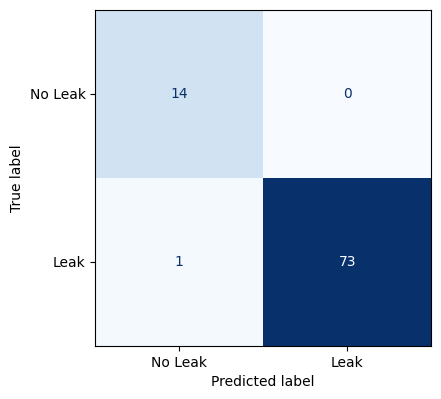

In [76]:
plot_confuse(y_true.iloc[:, 0].astype(int).to_numpy(), y_pred.iloc[:, 0].astype(int).to_numpy(), labels)

## Evaluate on Large Sample (Limit)

In [77]:
label = 'Limit'
temp_df = pd.read_excel(ROOT_PATH / f'data/external/crpwarner/dataset/large/sample/{label.lower()}.xlsx', index_col='Address')
temp_df['TP?'] = temp_df['TP?'].map({'Yes': 1, 'No': 0})
temp_df = temp_df.rename(columns={'TP?': label})
temp_df.index = temp_df.index.str.lower()

In [78]:
temp_df.head()

,Limit
Address,
0xe5f3c6d2b47cbe2cf936b9521466bac2422ebef8,1
0xa623b5a542c0d7daadef321042a04c600b03a8cb,1
0xe412189da2dfa188a1a61633114b8732bbbfba19,1
0x9fcf7acdc11fd904c4b73a009909c7f00efc4844,1
0x921a5dce3dfed5cccfbb2e593f2978533bc66110,1


In [79]:
res = requests.post(API_ENDPOINT + "/predict", json={"addresses": temp_df.index.to_list()})
print("Status:", res.status_code)
print("Elapsed:", res.elapsed.total_seconds(), "seconds")
res = res.json()['results']
df = pd.DataFrame.from_dict(res, orient="index")
df.head()

Status: 200
Elapsed: 304.757515 seconds


,labels,label_probs,anomaly,anomaly_score
0xe5f3c6d2b47cbe2cf936b9521466bac2422ebef8,"{'Address Restrict': 0, 'Amount Restrict': 1, ...","{'Address Restrict': 0.0382126769557718, 'Amou...",1,0.462258
0xa623b5a542c0d7daadef321042a04c600b03a8cb,"{'Address Restrict': 0, 'Amount Restrict': 0, ...","{'Address Restrict': 0.018721354330240796, 'Am...",1,0.462258
0xe412189da2dfa188a1a61633114b8732bbbfba19,"{'Address Restrict': 0, 'Amount Restrict': 0, ...","{'Address Restrict': 0.07091774129934543, 'Amo...",1,0.462258
0x9fcf7acdc11fd904c4b73a009909c7f00efc4844,"{'Address Restrict': 0, 'Amount Restrict': 0, ...","{'Address Restrict': 0.016461383458478366, 'Am...",1,0.462258
0x921a5dce3dfed5cccfbb2e593f2978533bc66110,"{'Address Restrict': 0, 'Amount Restrict': 0, ...","{'Address Restrict': 0.048491252370566174, 'Am...",1,0.462258


### Labels

In [80]:
label_df = pd.DataFrame.from_records(df['labels'].tolist(), index=df.index)
label_df.head()

,Address Restrict,Amount Restrict,Hidden Balance Modification,Hidden Mint/Burn,Leak,Limit,Mint,Modifiable External Call,Modifiable Tax Address,Modifiable Tax Rate,TimeStamp Restrict,Amount Limit,Exchange Permission,Exchange Suspension,Fee Manipulation,Invalid Callback,Trapdoor
0xe5f3c6d2b47cbe2cf936b9521466bac2422ebef8,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
0xa623b5a542c0d7daadef321042a04c600b03a8cb,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
0xe412189da2dfa188a1a61633114b8732bbbfba19,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
0x9fcf7acdc11fd904c4b73a009909c7f00efc4844,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
0x921a5dce3dfed5cccfbb2e593f2978533bc66110,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


In [81]:
y_true = temp_df
y_pred = label_df.loc[y_true.index, y_true.columns]

In [82]:
y_true.head()

,Limit
Address,
0xe5f3c6d2b47cbe2cf936b9521466bac2422ebef8,1
0xa623b5a542c0d7daadef321042a04c600b03a8cb,1
0xe412189da2dfa188a1a61633114b8732bbbfba19,1
0x9fcf7acdc11fd904c4b73a009909c7f00efc4844,1
0x921a5dce3dfed5cccfbb2e593f2978533bc66110,1


In [83]:
y_pred.head()

,Limit
Address,
0xe5f3c6d2b47cbe2cf936b9521466bac2422ebef8,1
0xa623b5a542c0d7daadef321042a04c600b03a8cb,1
0xe412189da2dfa188a1a61633114b8732bbbfba19,1
0x9fcf7acdc11fd904c4b73a009909c7f00efc4844,1
0x921a5dce3dfed5cccfbb2e593f2978533bc66110,1


In [84]:
labels = [f'No {label}', label]
print(classification_report(
  y_true.values,
  y_pred.values,
  target_names=labels,
  zero_division=0))

              precision    recall  f1-score   support

    No Limit       1.00      0.92      0.96        13
       Limit       0.99      1.00      0.99        79

    accuracy                           0.99        92
   macro avg       0.99      0.96      0.98        92
weighted avg       0.99      0.99      0.99        92



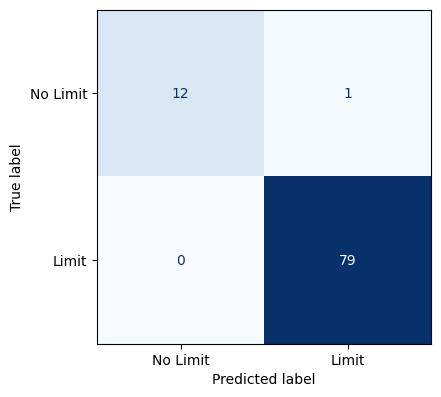

In [85]:
plot_confuse(y_true.iloc[:, 0].astype(int).to_numpy(), y_pred.iloc[:, 0].astype(int).to_numpy(), labels)

## Evaluate on RPHunter

In [92]:
rphunter_df = pd.read_csv(ROOT_PATH / 'data/rphunter-cleaned.csv', index_col='Address')
rphunter_df.index = rphunter_df.index.str.lower()

In [93]:
rphunter_df.head()

,Hidden Balance Modification,Hidden Mint/Burn,Address Restrict,Amount Restrict,Modifiable External Call,TimeStamp Restrict,Modifiable Tax Address,Modifiable Tax Rate
Address,,,,,,,,
0x93023f1d3525e273f291b6f76d2f5027a39bf302,0,1,0,0,0,0,0,1
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,0,0,0,0,0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,0,1,0,0,0,0,0,1
0x11cbc781dadaad13fc3a361772c80b1c027820af,0,0,1,0,0,0,0,0
0x3e597ea168a85aa2ae5e2c4333665bcd875ed10f,0,0,1,0,0,0,0,0


In [94]:
res = requests.post(API_ENDPOINT + "/predict", json={"addresses": rphunter_df.index.to_list()})
print("Status:", res.status_code)
print("Elapsed:", res.elapsed.total_seconds(), "seconds")
res = res.json()['results']
df = pd.DataFrame.from_dict(res, orient="index")
df.head()

Status: 200
Elapsed: 14744.691781 seconds


,labels,label_probs,anomaly,anomaly_score
0x93023f1d3525e273f291b6f76d2f5027a39bf302,"{'Address Restrict': 1, 'Amount Restrict': 1, ...","{'Address Restrict': 0.6057556970940429, 'Amou...",1,0.462258
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,"{'Address Restrict': 1, 'Amount Restrict': 0, ...","{'Address Restrict': 0.6905174535481907, 'Amou...",1,0.580088
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,"{'Address Restrict': 0, 'Amount Restrict': 0, ...","{'Address Restrict': 0.17137202234071047, 'Amo...",1,0.462258
0x11cbc781dadaad13fc3a361772c80b1c027820af,"{'Address Restrict': 1, 'Amount Restrict': 0, ...","{'Address Restrict': 0.7438377265564308, 'Amou...",1,0.580088
0x3e597ea168a85aa2ae5e2c4333665bcd875ed10f,"{'Address Restrict': 1, 'Amount Restrict': 0, ...","{'Address Restrict': 0.774213271528573, 'Amoun...",1,0.462258


### Labels

In [95]:
label_df = pd.DataFrame.from_records(df['labels'].tolist(), index=df.index)
label_df.head()

,Address Restrict,Amount Restrict,Hidden Balance Modification,Hidden Mint/Burn,Leak,Limit,Mint,Modifiable External Call,Modifiable Tax Address,Modifiable Tax Rate,TimeStamp Restrict,Amount Limit,Exchange Permission,Exchange Suspension,Fee Manipulation,Invalid Callback,Trapdoor
0x93023f1d3525e273f291b6f76d2f5027a39bf302,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,0,0,0,1,0,1,1,0,0,1,0,1,1,1,1,0,1
0x11cbc781dadaad13fc3a361772c80b1c027820af,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1
0x3e597ea168a85aa2ae5e2c4333665bcd875ed10f,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1


In [101]:
y_true = rphunter_df
y_pred = label_df.loc[y_true.index, y_true.columns]

In [102]:
y_true.head()

,Hidden Balance Modification,Hidden Mint/Burn,Address Restrict,Amount Restrict,Modifiable External Call,TimeStamp Restrict,Modifiable Tax Address,Modifiable Tax Rate
Address,,,,,,,,
0x93023f1d3525e273f291b6f76d2f5027a39bf302,0,1,0,0,0,0,0,1
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,0,0,0,0,0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,0,1,0,0,0,0,0,1
0x11cbc781dadaad13fc3a361772c80b1c027820af,0,0,1,0,0,0,0,0
0x3e597ea168a85aa2ae5e2c4333665bcd875ed10f,0,0,1,0,0,0,0,0


In [103]:
y_pred.head()

,Hidden Balance Modification,Hidden Mint/Burn,Address Restrict,Amount Restrict,Modifiable External Call,TimeStamp Restrict,Modifiable Tax Address,Modifiable Tax Rate
Address,,,,,,,,
0x93023f1d3525e273f291b6f76d2f5027a39bf302,0,0,1,1,0,1,1,0
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,0,0,0,0,0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,0,1,0,0,0,0,0,1
0x11cbc781dadaad13fc3a361772c80b1c027820af,0,0,1,0,0,0,0,0
0x3e597ea168a85aa2ae5e2c4333665bcd875ed10f,0,0,1,0,0,0,0,0


In [104]:
print(classification_report(
  y_true.values,
  y_pred.values,
  target_names=y_true.columns,
  zero_division=0))

                             precision    recall  f1-score   support

Hidden Balance Modification       0.67      0.54      0.60        61
           Hidden Mint/Burn       0.82      0.59      0.69       379
           Address Restrict       0.44      0.71      0.54       195
            Amount Restrict       0.39      0.81      0.53       136
   Modifiable External Call       1.00      1.00      1.00         1
         TimeStamp Restrict       0.08      0.93      0.15        15
     Modifiable Tax Address       0.12      0.70      0.21        27
        Modifiable Tax Rate       0.86      0.63      0.73        93

                  micro avg       0.46      0.66      0.54       907
                  macro avg       0.55      0.74      0.56       907
               weighted avg       0.63      0.66      0.61       907
                samples avg       0.56      0.61      0.56       907



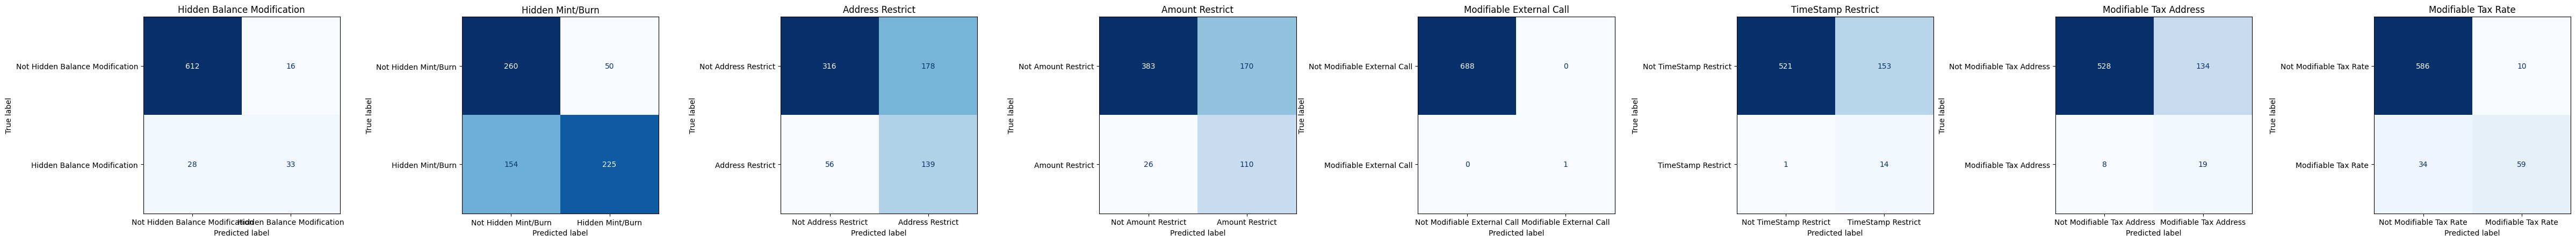

In [107]:
plot_confuse(y_true, y_pred)

### Anomaly

In [108]:
anomaly_true = (y_true.astype(int).sum(axis=1) > 0).astype(int)
anomaly_pred = df.loc[y_true.index, "anomaly"].astype(int)

In [109]:
labels = ['normal', 'anomaly']
print(classification_report(
  anomaly_true,
  anomaly_pred,
  target_names=labels,
  zero_division=0))

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        44
     anomaly       0.94      1.00      0.97       645

    accuracy                           0.94       689
   macro avg       0.47      0.50      0.48       689
weighted avg       0.88      0.94      0.91       689



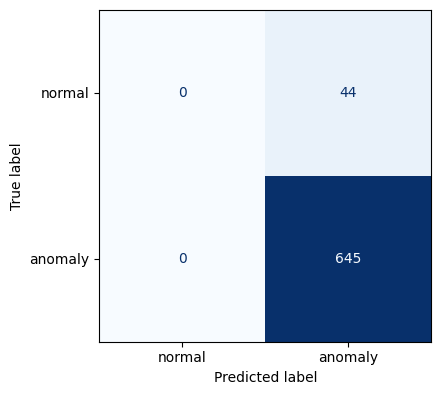

<Figure size 640x480 with 0 Axes>

In [110]:
plot_confuse(anomaly_true, anomaly_pred, labels)

## Evaluate on Trapdoor

In [116]:
trapdoor_df = pd.read_csv(ROOT_PATH / 'data/trapdoor.csv', index_col='Address')
trapdoor_df.index = trapdoor_df.index.str.lower()

In [117]:
trapdoor_df.head()

,Amount Limit,Exchange Permission,Exchange Suspension,Fee Manipulation,Invalid Callback,Trapdoor
Address,,,,,,
0x5674d4536fcd7a924696078b15865c4fab9f3597,0,1,0,0,0,1
0xbb7f05aa2dd33425ea0848cda8e4ea54718c6336,0,1,0,0,0,1
0x801427e0b00c5aa46f96550e1e33ad7f00077e19,0,1,0,0,0,1
0x1b49dc534fa67d0c23f6bd0601f8c8142f8306d0,0,1,0,0,0,1
0xf3afd0feac711f754d430de41ec0c7314a397ca1,0,1,0,0,0,1


In [124]:
# 5% of trapdoor dataset
random_df = trapdoor_df.sample(frac=0.01, random_state=42)
random_df.head()

,Amount Limit,Exchange Permission,Exchange Suspension,Fee Manipulation,Invalid Callback,Trapdoor
Address,,,,,,
0x8eb06dc3fb3b4c8b61797f31e77b650954de99b5,1,1,1,1,0,1
0x8212d0b1340f6dd339de0d8ebec9531418912b44,0,0,0,0,0,0
0xd8a0fbe83ccbbba32557a3e443605ba20e371466,1,1,1,1,0,1
0xba007ce10ec81bfdea5f095e83a05dacd5599bc1,0,1,0,0,0,1
0x37472814e5c6146e6ca7ed1753cd1b18b733e5d4,0,0,0,0,0,0


In [125]:
len(random_df)

422

In [126]:
res = requests.post(API_ENDPOINT + "/predict", json={"addresses": random_df.index.to_list()})
print("Status:", res.status_code)
print("Elapsed:", res.elapsed.total_seconds(), "seconds")
res = res.json()['results']
df = pd.DataFrame.from_dict(res, orient="index")
df.head()

Status: 200
Elapsed: 1261.531456 seconds


,labels,label_probs,anomaly,anomaly_score
0x8eb06dc3fb3b4c8b61797f31e77b650954de99b5,"{'Address Restrict': 1, 'Amount Restrict': 0, ...","{'Address Restrict': 0.4504729757444523, 'Amou...",1,0.803763
0x8212d0b1340f6dd339de0d8ebec9531418912b44,"{'Address Restrict': 0, 'Amount Restrict': 0, ...","{'Address Restrict': 0.27354142946583393, 'Amo...",1,0.580088
0xd8a0fbe83ccbbba32557a3e443605ba20e371466,"{'Address Restrict': 0, 'Amount Restrict': 0, ...","{'Address Restrict': 0.31694863119846783, 'Amo...",1,0.803763
0xba007ce10ec81bfdea5f095e83a05dacd5599bc1,"{'Address Restrict': 0, 'Amount Restrict': 1, ...","{'Address Restrict': 0.013966895243689468, 'Am...",1,0.462258
0x37472814e5c6146e6ca7ed1753cd1b18b733e5d4,"{'Address Restrict': 0, 'Amount Restrict': 0, ...","{'Address Restrict': 0.3651722488999948, 'Amou...",1,0.580088


### Labels

In [127]:
label_df = pd.DataFrame.from_records(df['labels'].tolist(), index=df.index)
label_df.head()

,Address Restrict,Amount Restrict,Hidden Balance Modification,Hidden Mint/Burn,Leak,Limit,Mint,Modifiable External Call,Modifiable Tax Address,Modifiable Tax Rate,TimeStamp Restrict,Amount Limit,Exchange Permission,Exchange Suspension,Fee Manipulation,Invalid Callback,Trapdoor
0x8eb06dc3fb3b4c8b61797f31e77b650954de99b5,1,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,1
0x8212d0b1340f6dd339de0d8ebec9531418912b44,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
0xd8a0fbe83ccbbba32557a3e443605ba20e371466,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,1
0xba007ce10ec81bfdea5f095e83a05dacd5599bc1,0,1,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1
0x37472814e5c6146e6ca7ed1753cd1b18b733e5d4,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1


In [128]:
y_true = random_df
y_pred = label_df.loc[y_true.index, y_true.columns]

In [129]:
y_true.head()

,Amount Limit,Exchange Permission,Exchange Suspension,Fee Manipulation,Invalid Callback,Trapdoor
Address,,,,,,
0x8eb06dc3fb3b4c8b61797f31e77b650954de99b5,1,1,1,1,0,1
0x8212d0b1340f6dd339de0d8ebec9531418912b44,0,0,0,0,0,0
0xd8a0fbe83ccbbba32557a3e443605ba20e371466,1,1,1,1,0,1
0xba007ce10ec81bfdea5f095e83a05dacd5599bc1,0,1,0,0,0,1
0x37472814e5c6146e6ca7ed1753cd1b18b733e5d4,0,0,0,0,0,0


In [130]:
y_pred.head()

,Amount Limit,Exchange Permission,Exchange Suspension,Fee Manipulation,Invalid Callback,Trapdoor
Address,,,,,,
0x8eb06dc3fb3b4c8b61797f31e77b650954de99b5,1,1,1,1,0,1
0x8212d0b1340f6dd339de0d8ebec9531418912b44,0,0,0,0,0,0
0xd8a0fbe83ccbbba32557a3e443605ba20e371466,1,1,1,1,0,1
0xba007ce10ec81bfdea5f095e83a05dacd5599bc1,0,1,0,0,0,1
0x37472814e5c6146e6ca7ed1753cd1b18b733e5d4,0,1,0,0,0,1


In [131]:
print(classification_report(
  y_true.values,
  y_pred.values,
  target_names=y_true.columns,
  zero_division=0))

                     precision    recall  f1-score   support

       Amount Limit       0.97      0.98      0.98       179
Exchange Permission       0.89      0.98      0.93       207
Exchange Suspension       0.98      0.92      0.95       181
   Fee Manipulation       0.98      0.98      0.98       179
   Invalid Callback       0.80      1.00      0.89         4
           Trapdoor       0.88      0.97      0.92       237

          micro avg       0.93      0.97      0.95       987
          macro avg       0.92      0.97      0.94       987
       weighted avg       0.93      0.97      0.95       987
        samples avg       0.54      0.53      0.54       987



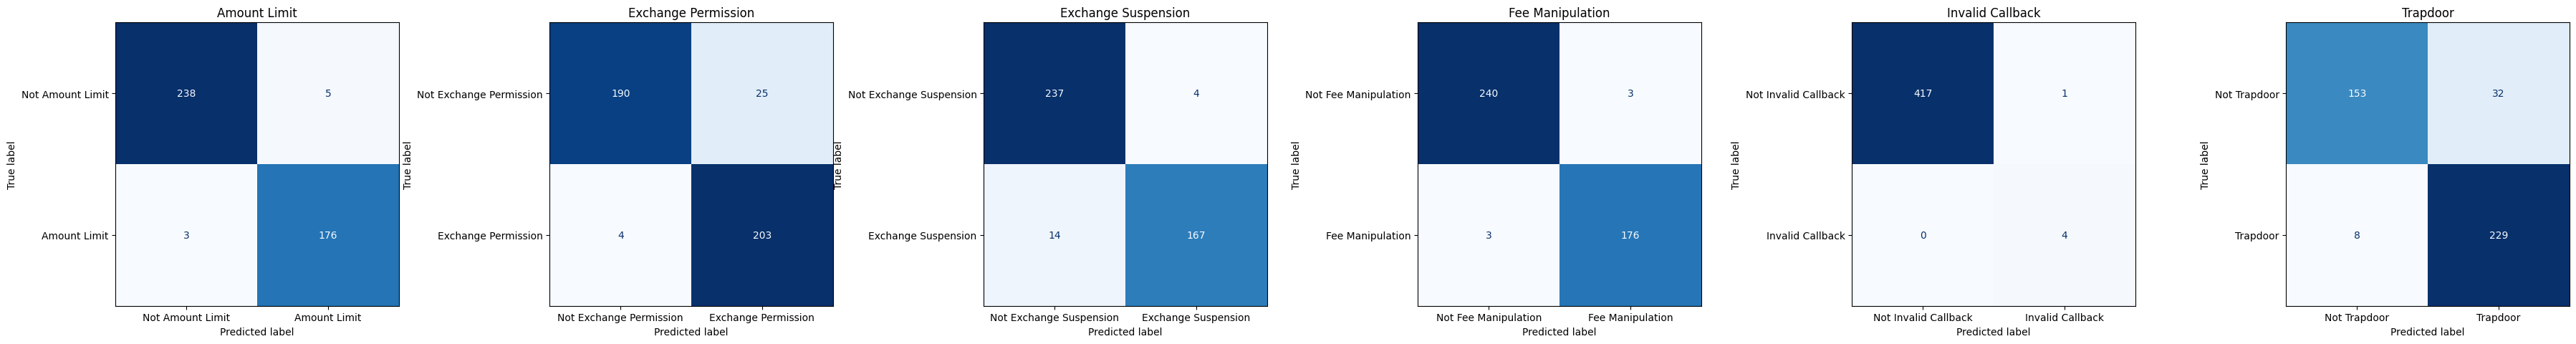

In [132]:
plot_confuse(y_true, y_pred)

### Anomaly

In [133]:
anomaly_true = (y_true.astype(int).sum(axis=1) > 0).astype(int)
anomaly_pred = df.loc[y_true.index, "anomaly"].astype(int)

In [134]:
labels = ['normal', 'anomaly']
print(classification_report(
  anomaly_true,
  anomaly_pred,
  target_names=labels,
  zero_division=0))

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       185
     anomaly       0.56      1.00      0.72       237

    accuracy                           0.56       422
   macro avg       0.28      0.50      0.36       422
weighted avg       0.32      0.56      0.40       422



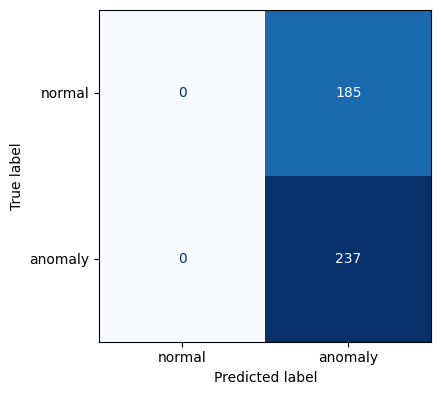

<Figure size 640x480 with 0 Axes>

In [135]:
plot_confuse(anomaly_true, anomaly_pred, labels)